In [2]:
import collections
import json
import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Library Imports

In [6]:
with open("data/results/indiv_and_pair_libs_count.json") as handle:
    libs_count = json.load(handle)
with open("data/results/indiv_and_pair_pairs_count.json") as handle:
    pairs_count = json.load(handle)
    
with open("data/results/indiv_and_pair_all_libs_dates.json") as handle:
    all_libs_dates = json.load(handle)
with open("data/results/indiv_and_pair_all_pairs_dates.json") as handle:
    all_pairs_dates = json.load(handle)
    
with open("data/results/indiv_and_pair_libs_first_dates.json") as handle:
    libs_first_dates = json.load(handle)
with open("data/results/indiv_and_pair_libs_first_dates.json") as handle:
    pairs_first_dates = json.load(handle)

# Posts to new libs and pairs

In [8]:
with open("data/results/post_to_new.json") as handle:
    data = json.load(handle)

In [9]:
t0 = time.time()
xs_libs = [d[0] for d in data['distinct_libs_plot']]
ys_libs = [d[1] for d in data['distinct_libs_plot']]
xs_pairs = [d[0] for d in data['distinct_pairs_plot']]
ys_pairs = [d[1] for d in data['distinct_pairs_plot']]
t1 = time.time()
print(f"Segments formed (took {round(t1 - t0, 2)} seconds).")

# Unique libs line fit
libs_a, libs_b  = np.polyfit(range(len(xs_libs)), ys_libs, 1)
pairs_a, pairs_b = np.polyfit(range(len(xs_pairs)), ys_pairs, 1)
t2 = time.time()
print(f"Fits performed (took {round(t2 - t1, 2)} seconds).")

Segments formed (took 0.01 seconds).
Fits performed (took 0.28 seconds).


[]

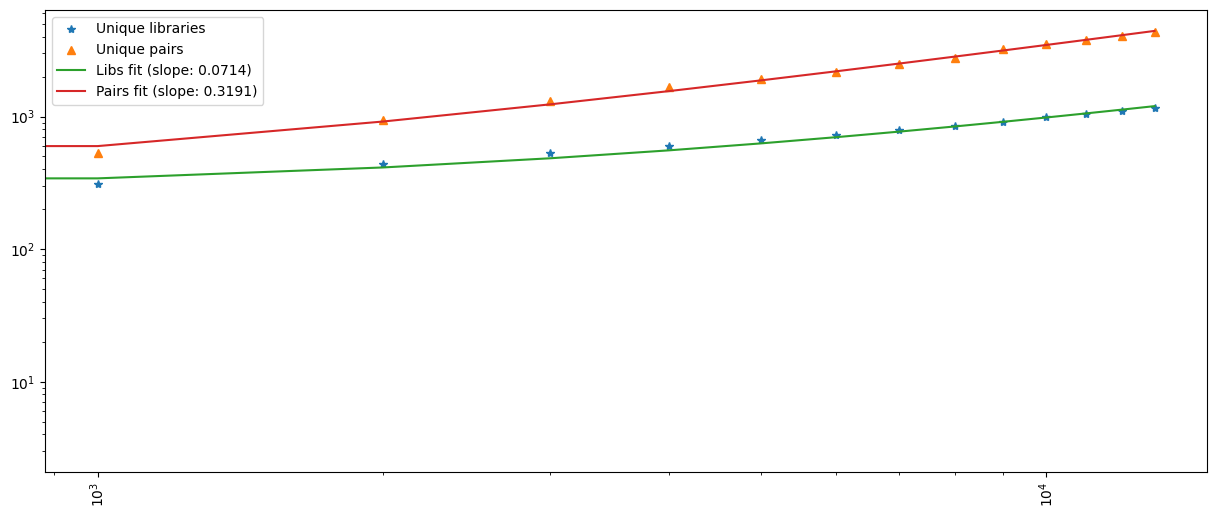

In [12]:
step_size = 1_000

plt.figure(figsize=(15,6))

plt.plot(range(0, len(xs_libs), step_size), ys_libs[::step_size], "*", label="Unique libraries")
plt.plot(range(0, len(xs_pairs), step_size), ys_pairs[::step_size], "^", label="Unique pairs")

plt.plot(range(0, len(xs_libs), step_size), [libs_a * x + libs_b for x in range(len(xs_libs))][::step_size], label=f"Libs fit (slope: {round(libs_a,4)})")
plt.plot(range(0, len(xs_pairs), step_size), [pairs_a * x + pairs_b for x in range(len(xs_pairs))][::step_size], label=f"Pairs fit (slope: {round(pairs_a, 4)})")

plt.xticks(rotation=90)
plt.legend(loc="upper left")
plt.loglog()

# Post count, lib count, pair count (y axis) against time (x axis)

In [ ]:
def present_sorted(d: dict)-> list:
    return sorted(d.items(), key=lambda x:x[1], reverse=True)

In [ ]:
time_buckets = {}
runner = datetime.datetime(2008, 1, 1)
delta = datetime.timedelta(days=1)
while runner < datetime.datetime(2024, 1, 1):
    time_buckets[]
    runner += delta

In [ ]:
first_lib

In [ ]:
big